# Setting up the environment

## Import the usual suspects
We'll want to plot something and use numpy for arrays and astropy for quantities and units.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import os
import astropy.units as u

## Define a function to inspect objects
To learn about the structure, we would like to have a function returning the important member variables of an object, but not the internal ones starting with a "_".

In [2]:
def filterdir(x):
    """ Run dir but filter out entries starting with _. """
    entries = [s for s in dir(x) if s[0] != "_"]
    return entries

Import the Data class from simdata. This is probably the only part you'll ever need as a user.

## Creating our fist Data object
The "Data" class is the interface of simdata. It's the part of the package you work with as a user.

In [3]:
from simdata import Data

Create a Data object for the fargo3d output from the RADMC3D & Fargo3d tutorial.
If you're brave and have your own Pluto/Fargo/Fargo3d data, go ahead and try another data dir.
If you didn't attend the fargo3d tutorial, get it from [here](https://www.tat.physik.uni-tuebingen.de/~rometsch/RUTD/fargo3d_output.tgz), save it and change datadir to the directory you unpacked.

In [4]:
datadir = os.path.expanduser("~/bormio_tutorial/fargo3d/outputs/fargo_multifluid/")
data = Data(datadir)

Let's inspect what Data has to offer:

In [5]:
filterdir(data)

['code',
 'fluids',
 'get_fluid',
 'loader',
 'parameters',
 'particlegroups',
 'planets']

Now we get to learn each of the entries to get familiar with the interface.

### Note: particle groups are not implemented yet
Because the authors do not use dust implemented as partic

## loaders and codes
If you initialize a Data object as above, simdata tries to determine a suitable loader for the data.
Currently the following are supported by simdata.

In [6]:
import simdata.loaders
for x in simdata.loaders.available:
    print(x)

('fargocpt', '0.1', 'legacy_output')
('fargo3d', '2.0', 'multifluid')
('PLUTO', '4.3', 'vanilla')
('PLUTO', '4.2', 'vanilla')
('exmaple_code', '0.1', 'test')


The example_code loader still hangs around for testing.
Now lets see which of these loaders simdata chose for the data we gave it.

In [7]:
data.code

('fargo3d', '2.0', 'multifluid')

It correctly identified the fargo3d loader

## Parameters
Analyzing simulation data, we often want to have access parameters as well. 
If the loader supports parameters, parameters are provided as a dict.

In [8]:
print("Type of parameters:",type(data.parameters))

Type of parameters: <class 'dict'>


Display the first 10:

In [9]:
n = 0
for key, value in data.parameters.items():
    print(key, ":", value)
    n += 1
    if n == 10: break

alpha : 0
aspect : auto
aspectratio : 0.05
autocolor : 1
beta : 0
cfl : 0.44
cmap : magma
colorbar : 1
coordinates : cylindrical
cs : 1


## Planets
Since the authors of this package run planet-disk interaction simulations, there is a dedicated part for planets. 

In [10]:
print(data.planets)

In this case, there is only one planet in the list. It is an object of the class Planet.

In [11]:
p = data.planets[0]
filterdir(p)

['alias',
 'get',
 'ids',
 'name',
 'nid',
 'register_alias',
 'register_particles',
 'register_variable',
 'variable_loaders']

You can ignore the "ids", "alias", "register_*" members.

### Info about planets

In [12]:
print("Id of the planet:", p.nid)

Id of the planet: 0


In [13]:
print("Name of the planet:", p.name)

Name of the planet: 0


Here, the both coincide, but they can be different depending on the naming of planets in the simulation code.

## get function
This function is used to get the data.

In [14]:
a = p.get("semi-major axis")

We just got the semi-major axis by specifing the human readable name. Without needing to know anything about the specifics of how fargo3d stores output data.

In [15]:
print("type of a:", type(a))
print("name of a:", a.name)
filterdir(a)

type of a: <class 'simdata.scalar.Scalar'>
name of a: semi-major axis


['data', 'get', 'get_closest_to_time', 'get_time_interval', 'name', 'time']

Variable a is of type **Scalar**. The most important things and the only ones we look at here are the **data** and **time** members.
Both are astropy quantities, so they have physical units!

In [16]:
print(a.time[:5])
print(a.data[:5])

[18707639.60354093 37415279.20708187 56122918.8106228  74830558.41440193
 93538198.01800242] s
[7.77909005e+13 7.77909226e+13 7.77909570e+13 7.77910002e+13
 7.77910481e+13] cm


Note again, that both of them have physical units. Every physical quantity in simdata is supposed to have a unit. Because otherwise its just a number, not a physical quantity.

In [17]:
print("type of a.time:", type(a.time))
print("unit of a.time:", a.time.unit)

type of a.time: <class 'astropy.units.quantity.Quantity'>
unit of a.time: s


To see, which quantities are available run:

In [18]:
for v in p.variable_loaders:
    print(v)

x
y
z
vx
vy
vz
mass
time step
physical time
physical time orbit
eccentricity
semi-major axis
mean anomaly
true anomaly
argument of periapsis
x-axis rotation angle
inclination
ascending node
longitude of periapsis


Looking at numbers is quite boring. So let's plot something. Since this planet is kept at a fixed orbit, the x coordinate is more interesting.

/home/rometsch/.local/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


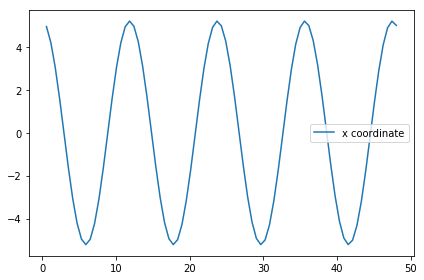

In [19]:
x = p.get("x")
plt.plot(x.time.to("yr"), x.data.to("au"), label="x coordinate")
plt.legend()

## Fluids
Because this package is developed for hydrodynamics simulations, we want to represent fluids.

A fluid is represented by physical fields (they have a value at every position in space) defined on a grid.

Currently only regular grids are supported. More on grids later.

In [20]:
data.fluids

{'dust1': <simdata.fluid.Fluid at 0x7fc8a893bfd0>,
 'dust2': <simdata.fluid.Fluid at 0x7fc8a88c9128>,
 'gas': <simdata.fluid.Fluid at 0x7fc8a88c9198>,
 'dust3': <simdata.fluid.Fluid at 0x7fc8a88c9208>}

Because we ran a simulation in which we modeled different dust species as fluids, there are 4 Fluid objects present in the data.

Now we pick the *gas* fluid for inspection, but the *dust* fluids work exactly the same.

In [21]:
gas = data.fluids["gas"]

In [22]:
print("type of gas:", type(gas))
print("members of the Fluid class")
filterdir(gas)

type of gas: <class 'simdata.fluid.Fluid'>
members of the Fluid class


['alias',
 'get',
 'get_grid',
 'get_time',
 'name',
 'register_alias',
 'register_variable',
 'variable_loaders']

Again ignoring some internal functions (alias, register_*) we are left with some functions and member variables to explore.

In [23]:
print("name of the fluid:" , gas.name)
print("available physical quantities:")
gas.variable_loaders

name of the fluid: gas
available physical quantities:


{'3d': {},
 '2d': {'mass density': <simdata.loaders.fargo3dmultifluid.FieldLoader2d at 0x7fc8a88c9470>,
  'energy density': <simdata.loaders.fargo3dmultifluid.FieldLoader2d at 0x7fc8a88c94e0>,
  'velocity radial': <simdata.loaders.fargo3dmultifluid.FieldLoader2d at 0x7fc8a88c9438>,
  'velocity azimuthal': <simdata.loaders.fargo3dmultifluid.FieldLoader2d at 0x7fc8a88c9588>},
 '1d': {'torque planet 0': <simdata.loaders.fargo3dmultifluid.FieldLoader1d at 0x7fc8a88c95f8>,
  'velocity radial': <simdata.loaders.fargo3dmultifluid.FieldLoader1d at 0x7fc8a88c9748>,
  'velocity azimuthal': <simdata.loaders.fargo3dmultifluid.FieldLoader1d at 0x7fc8a88c9780>},
 'scalar': {'mass': <simdata.loaders.fargo3dmultifluid.ScalarLoader at 0x7fc8a88c99b0>,
  'angular momentum': <simdata.loaders.fargo3dmultifluid.ScalarLoader at 0x7fc8a88c9a20>,
  'torque planet 0': <simdata.loaders.fargo3dmultifluid.ScalarLoader at 0x7fc8a88c99e8>}}

This is a dict containing loaders separated into 4 categories: scalar, 1d, 2d, 3d.

The reflect the data which was found by the loader. Since we specified a directory of a 2d simulation, there is no 3d data here.

We already saw the **Scalar** class in the planet example above, s

In [24]:
sigma = gas.get("2d", "mass density", 2)
type(sigma)

simdata.field.Field

Note that the data was only loaded now. The Field object gas only contains functions to load the data. So it only loads the data thats actually requested.

## Fields
Fields contain all information about a physical quantity defined on all points in space

Their dimension dim might be n=1,2 or 3.

The contain the values as a n-dim array as well as the grid information. This makes it quite easy to work with them.

In [25]:
filterdir(sigma)

['data',
 'get',
 'get_data',
 'get_grid',
 'get_name',
 'get_time',
 'grid',
 'name',
 'time']

A Field object knows to which time it belongs and what its called. Think about whether that could be useful for plotting.

In [26]:
sigma.time

<Quantity 7.48307334e+08 s>

In [27]:
sigma.name

'mass density'

The **data** member is a 2d astropy quantity.

In [28]:
print("type of sigma.data:", type(sigma.data))
print("dim of sigma.data:", sigma.data.ndim)
print("shape of sigma.data:", sigma.data.shape)

type of sigma.data: <class 'astropy.units.quantity.Quantity'>
dim of sigma.data: 2
shape of sigma.data: (128, 384)


This is essentially a numpy array with a unit.

We can plot the values this just like any other 2d array.

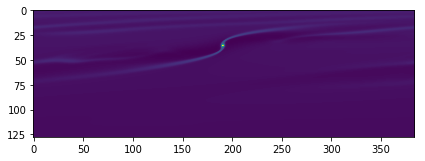

In [29]:
plt.imshow(sigma.data.cgs.value)

We can already see the spiral and density enhancement created by the planet. But notice the axis labels. They are just pixels. What we really want are physical positions. We would like to have information about the underlying grid.

## Grid
The Grid class contains all information about the grid. Currently the following grids are (partially) supported.

In [30]:
import simdata.grid
[s for s in filterdir(simdata.grid) if "Grid" in s]

['CartesianGrid',
 'CylindricalGrid',
 'Grid',
 'PolarGrid',
 'RegularGrid',
 'SphericalGrid']

RegularGrid and Grid are abstract classes from which the other inherit.

Note that only the PolarGrid is currently used, so the others might only partially work. If you encounter issues or limitations, please open an issue on the [github repository issue section](https://github.com/rometsch/simdata/issues).

### Skip the next section if you are not interested in staggered grids

Now lets inspect the grid of our sigma field.

In [31]:
g = sigma.grid
filterdir(g)

['active_interfaces',
 'dim',
 'get',
 'get_centers',
 'get_coordinates',
 'get_interfaces',
 'get_sizes',
 'names',
 'phi_c',
 'phi_d',
 'phi_i',
 'r_c',
 'r_d',
 'r_i']

x_i/c/d are the positions of interfaces or centeres and cellsizes (delta) of coordinate x

get_interfaces, get_centers and get_sizes return these values 

In [32]:
print("interfaces r:", g.get_interfaces("r")[:10])
print("centers r:", g.get_centers("r")[:10])

interfaces r: [3.11163572e+13 3.23926140e+13 3.36688708e+13 3.49451277e+13
 3.62213845e+13 3.74976414e+13 3.87738982e+13 4.00501550e+13
 4.13264119e+13 4.26026687e+13] cm
centers r: [3.17544856e+13 3.30307424e+13 3.43069993e+13 3.55832561e+13
 3.68595129e+13 3.81357698e+13 3.94120266e+13 4.06882834e+13
 4.19645403e+13 4.32407971e+13] cm


Here you can see, that each position of a center lies in between two interface positions. 

get_coordinates returns either the center positions or the interface positions, depending on whether the quantity to which the grid belongs to is defined on the interfaces of the cell or in the center.

To make this clearer, lets have a look at the radial velocity. The $v_\text{rad}$ is defined on the radial interfaces in Fargo3d, so we expect to get these by running get_coordinates.

In [33]:
vrad = gas.get("2d", "velocity radial", 2)
print("vrad defined on radial interface:", all(vrad.grid.get_coordinates("r") == vrad.grid.get_interfaces("r")))
print("vrad defined on azimuthal center:", all(vrad.grid.get_coordinates("phi") == vrad.grid.get_centers("phi")))

vrad defined on radial interface: True
vrad defined on azimuthal center: True


### Comming back to the density plot
Now we would like to plot the surface density with physical coordinates.

In [34]:
r = sigma.grid.get_coordinates("r")
phi = sigma.grid.get_coordinates("phi")

This is all we have to do to get the data. Now some standard plotting...

Text(0.5, 0, 'y [au]')

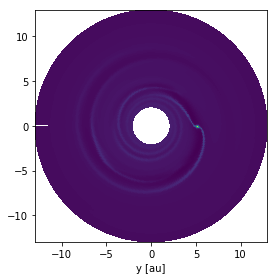

In [44]:
# make a meshgrid for pcolormesh
PHI, R = np.meshgrid(phi, r)
X = R*np.cos(PHI)
Y = R*np.sin(PHI)

plt.pcolormesh(X.to("au"),Y.to("au"), sigma.data)
ax = plt.gca()
ax.set_aspect("equal")
ax.set_xlabel("x [au]")
ax.set_xlabel("y [au]")

## Bonus: if you have smurf installed

Go to the simulation data you just loaded and initialize a new simulation with **smurf init** and add it to the cache with **smurf cache --notify**

In my case the data directory was ~/bormio_tutorial/fargo3d/outputs/fargo_multifluid/

In [54]:
os.chdir(datadir)

In [53]:
!smurf init

uuid = 9cc744e9-d9ad-4657-8755-4116e89a89cd
name = fargo_multifluid


In [55]:
!smurf cache --notify

simdata has a smurf plugin.
This makes it possible to load the data by giving an id or a name of a simulation like so:

In [45]:
from simdata import SData

In [56]:
data = SData("9cc744e9")

In [57]:
data.path

'/home/rometsch/bormio_tutorial/fargo3d/outputs/fargo_multifluid'

You can do the same things with this data object like above.

If you setup smurf on a remote host with data you can load with simdata, try the same thing. Smurf mounts the data for you in the background and unmounts it again when everything is done.